<a href="https://colab.research.google.com/github/fengivan/382L-HW5/blob/master/HW5Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [311]:
import numpy as np
import sys
import math
import scipy.linalg as la
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=sys.maxsize)

In [312]:
def exact(x, y, t):                           #gives the exact solution to the function U(x,y,t)
  return math.exp(-t)*(x**2+y**2)+1  
  

In [ ]:
def solu(time, size):                               #returns a matrix with the exact solution at any time
  deltax=1/(size-1)
  deltay=1/(size-1)
  out=np.zeros((size,size))                
  for i in range(0,size):
    for j in range(0,size):
      out[i,j]=exact(i*deltax, j*deltay, time)
  return out

In [313]:
def getInitial(size):                         #set initial conditions for U(x,y,0). This function returns a size by size matrix with the values of U at every position
  deltax=1/(size-1)                           #if size is 21, deltax is 1/20. grid positions range from 0,.05,.1,.15.....95,1
  deltay=1/(size-1)
  U=np.zeros((size,size))
  U = U.astype(float)
  for i in range(0,size):
    for j in range(0,size):
      U[i,j]=exact(i*deltax, j*deltay, 0)     #set U[i,j] to the exact solution

  U=U.reshape(size*size,1)                    #reshape it from a matrix to a vector, U00,U01,U02,U03..U10,U11,U12.... 

  return U

In [314]:
def getA(r, g, size):                         #create the banded matrix for U(n+1) 
  A=np.identity(size)
  A=np.concatenate((A,np.tile(np.zeros((size,size)), size-1)), axis=1)
  
  D=np.identity(size)
  E=np.zeros((size, size))
  zeros=0
  
  for i in range(1, size-1):
    D[i, zeros]=r
    D[i, zeros+1]=g
    D[i, zeros+2]=r
    E[i, zeros+1]=r
    zeros+=1
  
  zeros=0
  for i in range(0, size-2):
    temp=np.concatenate((np.tile(np.zeros((size, size)),i),E,D,E,np.tile(np.zeros((size, size)),size-3-i)), axis=1)
    A=np.concatenate((A,temp),axis=0)
  
  temp=np.concatenate((np.tile(np.zeros((size, size)),size-1), np.identity(size)), axis=1)

  A=np.concatenate((A,temp), axis=0)
  return A

In [340]:
def getB(r, g, size):                         #create the banded matrix for U(n)
  A=np.zeros((size,size))
  A=np.concatenate((A,np.tile(np.zeros((size,size)), size-1)), axis=1)
  
  D=np.zeros((size, size))
  E=np.zeros((size, size))
  zeros=0
  
  for i in range(1, size-1):
    D[i, zeros]=r
    D[i, zeros+1]=g
    D[i, zeros+2]=r
    E[i, zeros+1]=r
    zeros+=1
  
  zeros=0
  for i in range(0, size-2):
    temp=np.concatenate((np.tile(np.zeros((size, size)),i),E,D,E,np.tile(np.zeros((size, size)),size-3-i)), axis=1)
    A=np.concatenate((A,temp),axis=0)
  
  temp=np.concatenate((np.tile(np.zeros((size, size)),size-1), np.zeros((size, size))), axis=1)

  A=np.concatenate((A,temp), axis=0)
  return A

In [341]:
def getC(n, size, deltat):                                          #create the vector of constants/boundry conditions
  deltax=1/(size-1)
  deltay=1/(size-1)
  C=np.zeros((size,size))                                           #make C initially a matrix, reshape to vector later

  for i in range(0, size):    
    for j in range(0, size):
      if  not (i ==0 or j==0 or i == size-1 or j == size -1):       #if i,i is not on a boundry (x=0,y=0,x=1,y=1)
        C[i,j]=-math.exp(-n*deltat)*(4+(i*deltax)**2+(j*deltay)**2) #C[i,j] is equal to the differential term -e^(-t)*(4+x^2+y^2)
      else:
        C[i,j]=exact(i*deltax, j*deltay, n*deltat)                  #C[i,j] is equal to the exact boundry condition if i,j is on a boundry

  return C.reshape(size*size,1)                                     #reshape C into a vector


In [371]:
def getU(time):                               #returns U at the given time, using a 21x21 gird (x,y from 0 to 1 inclusive, deltax=deltay=1/20), deltat = .01
  size=21                                     #set some parameters
  deltax=1/(size-1)
  deltat=.01
  deltay=1/(size-1)


  r=-1/(2*deltax**2)                          #coefficients
  g=2/(deltax**2)+1/deltat
  h=1/deltat-2/(deltax**2)

  U=getInitial(size)                          #get the matricies
  A=getA(r,g, size)
  B=getB(-r,h,size)

  for n in range(0, round(time/deltat)):        #iterate through time from 0 to t=.2(n from 0 to 20)
    C=getC(n, size, deltat)                     
    lhs=np.matmul(B, U)+C                       #the left hand side of the system is B * U at n plus C
    U=np.linalg.solve(A, lhs)                   #solve matrix equation Ax=lhs

  U=U.reshape(size,size)                        #resize U to a size by size matrix


  return U




Error of numerical solution at T=.2
[[0.     0.     0.0001 0.0002 0.0003 0.0005 0.0007 0.001  0.0013 0.0017 0.0021 0.0025 0.003  0.0035 0.004  0.0046 0.0053 0.0059 0.0067 0.0074 0.0082]
 [0.     0.0001 0.0002 0.0004 0.0005 0.0007 0.001  0.0013 0.0016 0.0019 0.0023 0.0028 0.0032 0.0037 0.0043 0.0049 0.0055 0.0061 0.0068 0.0075 0.0082]
 [0.0001 0.0002 0.0004 0.0005 0.0007 0.001  0.0012 0.0015 0.0019 0.0022 0.0026 0.0031 0.0035 0.004  0.0046 0.0051 0.0057 0.0063 0.007  0.0076 0.0083]
 [0.0002 0.0004 0.0005 0.0008 0.001  0.0012 0.0015 0.0018 0.0021 0.0025 0.0029 0.0033 0.0038 0.0043 0.0048 0.0054 0.006  0.0066 0.0072 0.0078 0.0084]
 [0.0003 0.0005 0.0007 0.001  0.0012 0.0015 0.0018 0.0021 0.0024 0.0028 0.0032 0.0036 0.0041 0.0046 0.0051 0.0056 0.0062 0.0068 0.0074 0.008  0.0086]
 [0.0005 0.0007 0.001  0.0012 0.0015 0.0018 0.0021 0.0024 0.0027 0.0031 0.0035 0.0039 0.0044 0.0049 0.0054 0.0059 0.0065 0.007  0.0076 0.0082 0.0087]
 [0.0007 0.001  0.0012 0.0015 0.0018 0.0021 0.0024 0.0027 0.003 

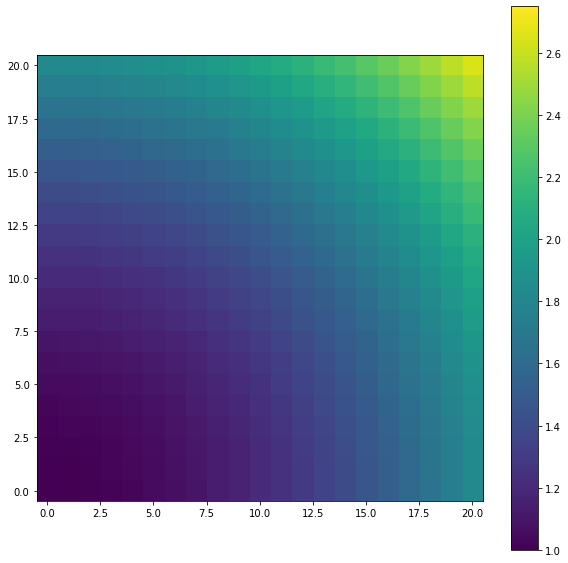

Exact solution at T=.2


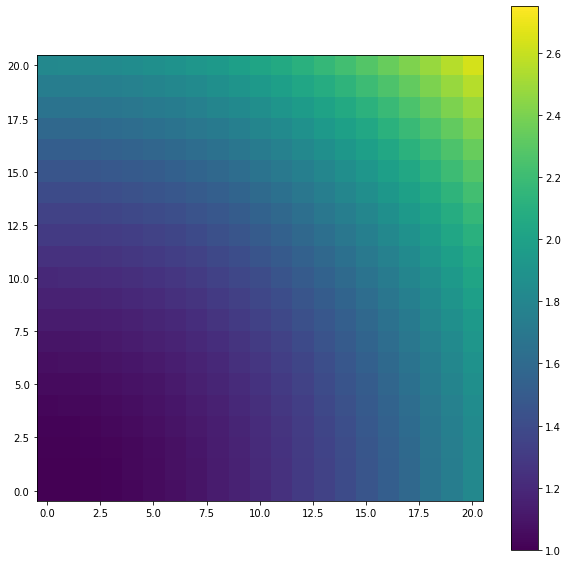

Percent Error at T=.2


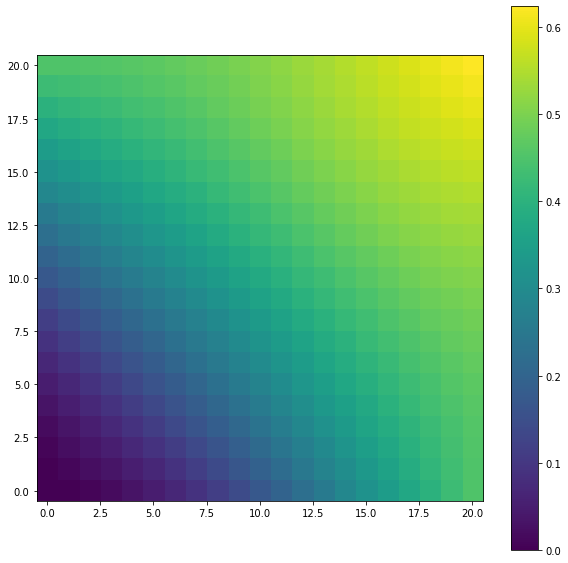

In [397]:
exactfinal=solu(.2, 21)       #get exact and numerical solutions at t=.2 to compare
numericalfinal=getU(.2)

exactmid=solu(.1,21)          #get exact and numerical solutions at t=.1 to compare
numericalmid=getU(.1)

print("Error of numerical solution at T=.2")        #compare error
print(np.around((numericalfinal-exactfinal),4))
print("Error of numerical solution at T=.1")
print(np.around((numericalmid-exactmid),4))
print("Numerical solution at T=.2")
plt.imshow(numericalfinal)        #plot numerical solution at t=.2
plt.colorbar()
plt.gca().invert_yaxis()
plt.clim(1, 2.75)
plt.show()
print("Exact solution at T=.2")
plt.imshow(exactfinal)      #plot exact solution at t=.2
plt.colorbar()
plt.clim(1, 2.75)
plt.gca().invert_yaxis()
plt.show()
print("Percent Error at T=.2")
plt.imshow(100*(numericalfinal-exactfinal)/exactfinal)      #plot percent error 
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()
